# Stellar Classification

## Imports

In [667]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, minmax_scale
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Read the data and take a first look

In [668]:
df = pd.read_csv("/content/star_classification.csv")

In [669]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

The dataset has no null entries, but we will still need to check for outliers

In [670]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


Note the -9999 values as min for columns u, g, and z. Is this missing/bad data?

GALAXY    59445
STAR      21594
QSO       18961
Name: class, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


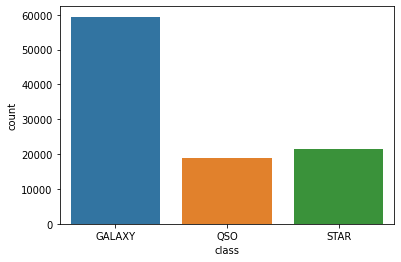

In [671]:
print(df['class'].value_counts())
sns.countplot('class', data=df);
bad_index = df[df['g'] == -9999].index[0]
df.drop([bad_index], inplace=True) #drop the bad data
df.reset_index(drop=True, inplace=True)

As you can see, this is an unbalanced dataset. There are significantly more 'GALAXY' entries than 'QSO' and 'STAR'

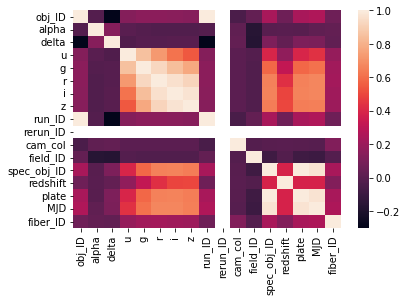

In [672]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns);

# Data Visualization / Preprocessing

### Dropping ID columns


In [673]:
df.drop(columns=['obj_ID', 'run_ID', 'rerun_ID', 'field_ID','fiber_ID', 'spec_obj_ID', 'MJD', 'cam_col'], inplace=True)

### Remaining columns

Columns ['u', 'g', 'z'] and ['r', 'i'] correlate to the other columns in almost excactly same way. 'r' and 'i' are different enough with regards to redshift (our biggest predictor) so we will keep them.

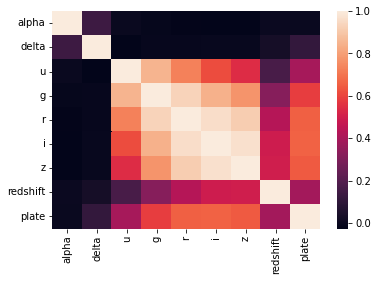

In [674]:
sns.heatmap(df.corr());

### Final columns

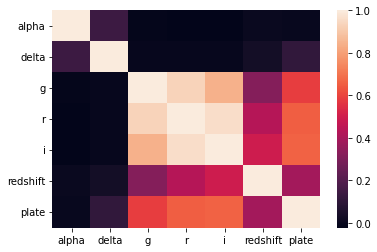

In [675]:
df.drop(columns=['u', 'z'], inplace=True)
sns.heatmap(df.corr()); 


### Pairplot

'redshift', 'g', and 'redshift' vs 'g' show to be very good at classifying, with each class clearly having its own value range for each.

In [676]:
#sns.pairplot(df, hue='class')

### One Hot Encoding

In [677]:
enc = OneHotEncoder()
enc_df = pd.DataFrame(enc.fit_transform(df[['class']]).toarray())
enc_df.columns = ['GALAXY', 'QSO', 'STAR']
df = pd.concat([df, enc_df], axis=1)

## Forward Selection - Manual Testing

Selecting Predictors

In [678]:
targets = ['GALAXY', 'QSO', 'STAR']

# run 1
predictors = ['alpha', 'delta', 'g', 'r', 'i', 'redshift', 'plate']

# run 2
# redshift provides highest accuracy:
# predictors = ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'cam_col', 'plate']

# run 3
# g + redshift provides highest accuracy:
# predictors = ['alpha', 'delta', 'u', 'r', 'i', 'z', 'cam_col', 'plate']

# run 4
# r + g + redshift provides highest accuracy:
# predictors = ['alpha', 'delta', 'u', 'i', 'z', 'cam_col', 'plate']

# run 5
# i + r + g + redshift provides highest accuracy:
# predictors = ['alpha', 'delta', 'u','z', 'cam_col', 'plate']

Getting Accuracy

In [679]:
for p in predictors:
  # run 1 - for all predictors:
  X = df[[p]].values

  # run 2
  # redshift provides highest accuracy: 94.31, add to predictors
  # X = df[[p, 'redshift']].values

  # run 3
  # g + redshift provides highest accuracy: 95.4, add to predictors
  # X = df[[p, 'redshift', 'g']].values

  # run 4
  # r + g + redshift provides highest accuracy: 95.08, add to predictors
  # X = df[[p, 'redshift', 'g', 'r']].values

  # run 5
  # i + r + g + redshift provides highest accuracy: 93.86
  # X = df[[p, 'redshift', 'g', 'r', 'i']].values

  y = df[targets].values

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)

  # implement kNN classification with default value of k
  knn = KNeighborsClassifier(weights='distance', metric='manhattan')
  knn.fit(X_train, y_train)

  # get predictions
  predictions = knn.predict(X_test)

  predictions_enc = pd.DataFrame(predictions).idxmax(axis=1)
  y_test_enc = pd.DataFrame(y_test).idxmax(axis=1)

  print (p, (predictions_enc == y_test_enc).mean())

alpha 0.5087
delta 0.5057666666666667
g 0.5365
r 0.5025
i 0.5214
redshift 0.9312
plate 0.6950333333333333


## Set Predictors and Targets

In [680]:
# Set predictors and targets
predictors = ['alpha', 'delta', 'g', 'r', 'i', 'redshift', 'plate']
targets = ['GALAXY', 'QSO', 'STAR']

X = df[predictors].values
y = df[targets].values

##Train, Test, Split

In [681]:
#Train, Test, Split (Random Seed 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choosing a model

##KNN Exploration


In [682]:
#WARNING, COSTLY COMPUTATIONS
from sklearn.model_selection import GridSearchCV

#use gridsearch on cross validation to find the best n and p for knn
#n_sqrt = round(np.sqrt(X_train.shape[0]))
#grid = [{'n_neighbors': [3, 5, 7, 9, n_sqrt], 'p':[1,2]}]
#knnCV = GridSearchCV(KNeighborsClassifier(), grid, cv=10, scoring='accuracy') #This takes about a minute on my PC, will likely take around 5-10x that on google collab
#knnCV.fit(X_train, y_train)
#print(knnCV.best_params_)

#Best hyperparameters evaluate to {'n_neighbors': 3, 'p': 1}, so 3 neighbors and the distance algorithm being the manhattan distance
#This will likely change as it is possible that we are overfitting

###Run tests to confirm that our number of neighbors and distance algorithm are indeed the best

In [683]:
#WARNING, COSTLY COMPUTATIONS
from sklearn.model_selection import cross_val_score

scores_df = pd.DataFrame({'dist_algorithm':[], 'n_neighbors':[], 'accuracy':[]})

#Loop version

#n_neighbors_list = {3, 5, 7, 9, round(np.sqrt(X_train.shape[0]))}
#dist_algorithms = {1, 2}
#for n in n_neighbors_list:
    #for dist_algorithm in dist_algorithms:
        #knn = KNeighborsClassifier(n_neighbors = n, p = dist_algorithm)
        #scores = cross_val_score(knn, X_train, y_train, scoring='accuracy', cv=10) #cv = 10
        #df_temp = pd.DataFrame([[dist_algorithm, n, scores.mean()]], columns=['dist_algorithm', 'n_neighbors', 'accuracy'])
        #scores_df = pd.concat([scores_df, df_temp])

### Learning Curves

In [684]:
from sklearn.model_selection import learning_curve

#cell height
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

#WARNING, EXTREMELY COSTLY COMPUTATIONS
#14mins on local, likely much more on colab

#n_neighbors_list = [3, 5, 7, 9, round(np.sqrt(X_train.shape[0]))]
#fig, axs = plt.subplots(len(n_neighbors_list), figsize=(15,30))
#learning_curve_df = pd.DataFrame({ 'n_neighbors':[], 'train_scores_mean':[], 'test_scores_mean': []})

#for i in range(len(n_neighbors_list)):
    #knn = KNeighborsClassifier(n_neighbors = n_neighbors_list[i], p = 1) #Manhattan distance
    #train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=10, scoring='accuracy')
    #train_scores_mean = np.mean(train_scores, axis=1)
    #test_scores_mean = np.mean(test_scores, axis=1)
    #df_temp = pd.DataFrame([[n_neighbors_list[i], train_scores_mean, test_scores_mean]], columns=['n_neighbors', 'train_scores_mean', 'test_scores_mean'])
    #learning_curve_df = pd.concat([learning_curve_df, df_temp], ignore_index=True)
    #axs[i].plot(train_sizes, train_scores_mean, label='train')
    #axs[i].plot(train_sizes, test_scores_mean, label='test')
    #axs[i].legend()
    #title = "Learning curve, KNN, n_neighbors=" + str(n_neighbors_list[i]) + ", all numeric predictors"
    #axs[i].set_title(title)
    

<IPython.core.display.Javascript object>

### Predictors 'g' and 'redshift'

In [685]:
#cell height
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 10000})'''))

#n_neighbors_list = [3, 5, 7, 9, 15, 25, 50, 100, 150, 200, round(np.sqrt(X_train.shape[0]))]#14mins
#fig, axs = plt.subplots(len(n_neighbors_list), figsize=(15,30))
#learning_curve_df = pd.DataFrame({ 'n_neighbors':[], 'train_scores_mean':[], 'test_scores_mean': []})

#for i in range(len(n_neighbors_list)):
    #knn = KNeighborsClassifier(n_neighbors = n_neighbors_list[i], p = 1) #Manhattan distance
    #train_sizes, train_scores, test_scores = learning_curve(knn, X_train, y_train, cv=10, scoring='accuracy')
    #train_scores_mean = np.mean(train_scores, axis=1)
    #test_scores_mean = np.mean(test_scores, axis=1)
    #df_temp = pd.DataFrame([[n_neighbors_list[i], train_scores_mean, test_scores_mean]], columns=['n_neighbors', 'train_scores_mean', 'test_scores_mean'])
    #learning_curve_df = pd.concat([learning_curve_df, df_temp], ignore_index=True)
    #axs[i].plot(train_sizes, train_scores_mean, label='train')
    #axs[i].plot(train_sizes, test_scores_mean, label='test')
    #axs[i].legend()
    #title = "Learning curve, KNN, n_neighbors=" + str(n_neighbors_list[i]) + ", predictors 'g' and 'redshift'"
    #axs[i].set_title(title)

#for ax in axs.flat:
    #ax.set(xlabel='Training set size', ylabel='Accuracy')

<IPython.core.display.Javascript object>

## Logistic Regression Exploration


### Label Encoding

In [686]:
df['class_cat'] = df['class'].astype('category').cat.codes

### Learning Curves for each solver

As we can see, liblinear provides the best learning curve

In [687]:
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'] #default=’lbfgs’
# fig, axs = plt.subplots(len(solver), figsize=(15,100))
# learning_curve_df = pd.DataFrame({ 'solver':[], 'train_scores_mean':[], 'test_scores_mean': []})

##Scaling is done again below, beware!
## scaler = StandardScaler()
## X_train = scaler.fit_transform(X_train)

# for i in range(len(solver)):
#     regr = LogisticRegression(solver=solver[i])
#     train_sizes, train_scores, test_scores = learning_curve(regr, X_train, y_train, cv=10, scoring='accuracy')
#     train_scores_mean = np.mean(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     df_temp = pd.DataFrame([[solver[i], train_scores_mean, test_scores_mean]], columns=['solver', 'train_scores_mean', 'test_scores_mean'])
#     learning_curve_df = pd.concat([learning_curve_df, df_temp], ignore_index=True)
#     axs[i].plot(train_sizes, train_scores_mean, label='train')
#     axs[i].plot(train_sizes, test_scores_mean, label='test')
#     axs[i].legend()
#     title = "Learning curve, Logistic Regression, solver=" + str(solver[i]) + ", predictors 'alpha', 'delta', 'g', 'r', 'redshift', 'plate'"
#     axs[i].set_title(title)

# for ax in axs.flat:
#     ax.set(xlabel='Training set size', ylabel='Accuracy')

### Drop labels

In [688]:
df.drop(columns=['class_cat'], inplace=True)

## Decision Tree Classifier Exploration

### Testing different hyperparameters

Default hyperparameters provide the best accuracy

In [689]:
# min_samples_split = np.arange(10, 35, 5)
# max_depth = np.arange(1, 4)
# min_samples_leaf = np.arange(10, 50, 10)
# max_leaf_nodes = np.arange(4, 16)
# min_impurity_decrease = np.linspace(0.05, 0.5, 10)

# for split in min_samples_split:
#     for depth in max_depth:
#         for min_leaf in min_samples_leaf:
#             for max_leaf in max_leaf_nodes:
#                 for decrease in min_impurity_decrease:
#                     print("Working on: split:", split, 'depth:', depth, 'min_leaf:', min_leaf, 'max_leaf:', max_leaf, 'decrease:', decrease)
#                     clf = DecisionTreeClassifier(max_depth = depth, min_samples_split=split, min_samples_leaf=min_leaf, max_leaf_nodes=max_leaf, min_impurity_decrease=decrease)
#                     clf.fit(X_train, y_train)
#                     train_predict = clf.predict(X_train)
#                     train_error = (train_predict != y_train).mean()
#                     test_predict = clf.predict(X_test)
#                     test_error = (test_predict != y_test).mean()
#                     train_accuracy = 1 - train_error
#                     test_accuracy = 1 - test_error
#                     df_result = pd.DataFrame([[split, depth, min_leaf, max_leaf, decrease, train_accuracy, test_accuracy, train_error, test_error, predictors]], columns = ['min_samples_split', 'max_depth', 'min_samples_leaf', 'max_leaf_nodes', 'min_impurity_decrease', 'train_accuracy', 'test_accuracy', 'train_error', 'test_error', 'predictors'])
#                     df_hyperparameter_scores = pd.concat([df_hyperparameter_scores, df_result], ignore_index=True)

#default
#clf = DecisionTreeClassifier()
#clf.fit(X_train, y_train)
#train_predict = clf.predict(X_train)
#train_error = (train_predict != y_train).mean()
#test_predict = clf.predict(X_test)
#test_error = (test_predict != y_test).mean()
#train_accuracy = 1 - train_error
#test_accuracy = 1 - test_error
#df_result = pd.DataFrame([[2, None, 1, None, 0.0, train_accuracy, test_accuracy, train_error, test_error, predictors]], columns = ['min_samples_split', 'max_depth', 'min_samples_leaf', 'max_leaf_nodes', 'min_impurity_decrease', 'train_accuracy', 'test_accuracy', 'train_error', 'test_error', 'predictors'])
#df_hyperparameter_scores = pd.concat([df_hyperparameter_scores, df_result], ignore_index=True)

# print('Train Scores:\n', df_hyperparameter_scores.sort_values(by='train_accuracy').head(10))
# print('Test Scores:\n', df_hyperparameter_scores.sort_values(by='test_accuracy').head(10))

# Testing Models using best parameters from exploration

### Scale X_train and X_test

In [690]:
# Scale X_train and X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## kNN Classification

Accuracy:  0.95145
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     11904
           1       0.96      0.91      0.93      3810
           2       0.94      0.95      0.94      4286

    accuracy                           0.95     20000
   macro avg       0.95      0.94      0.94     20000
weighted avg       0.95      0.95      0.95     20000

[[11517   142   245]
 [  321  3452    37]
 [  225     1  4060]]


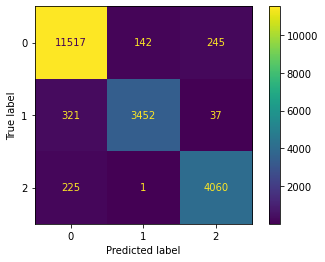

In [691]:
knn = KNeighborsClassifier(weights='distance', metric='manhattan')
knn.fit(X_train, y_train)

# get predictions
predictions = knn.predict(X_test)

# inverse the one hot encoding
predictions_enc = pd.DataFrame(predictions).idxmax(axis=1)
y_test_enc = pd.DataFrame(y_test).idxmax(axis=1)
# print accuracy
print('Accuracy: ', (predictions_enc == y_test_enc).mean())

# print classification report
print(classification_report(y_test_enc, predictions_enc))

# print confusion matrix
print(confusion_matrix(y_test_enc, predictions_enc))

# display confusion matrix as heatmap
ConfusionMatrixDisplay.from_predictions(y_test_enc, predictions_enc)

## Decision Tree Classification

Feature Importances:  [0.00847918 0.00849074 0.06255111 0.01093077 0.01842718 0.87858463
 0.01253641]
Depth:  31
Accuracy:  0.964
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     11904
           1       0.91      0.91      0.91      3810
           2       1.00      1.00      1.00      4286

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

[[11548   341    15]
 [  346  3464     0]
 [   13     5  4268]]


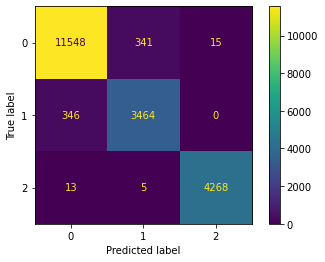

In [692]:
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

print('Feature Importances: ', clf.feature_importances_)

# get predictions
predictions = clf.predict(X_test)

# inverse one hot encoding
predictions_enc = pd.DataFrame(predictions).idxmax(axis=1)
y_test_enc = pd.DataFrame(y_test).idxmax(axis=1)

# print the depth of the tree
print('Depth: ', clf.tree_.max_depth)

# print accuracy
print('Accuracy: ', (predictions_enc == y_test_enc).mean())

# print classification report
print(classification_report(y_test_enc, predictions_enc))

# print confusion matrix
print(confusion_matrix(y_test_enc, predictions_enc))

# display confusion matrix as heatmap
ConfusionMatrixDisplay.from_predictions(y_test_enc, predictions_enc)

The decision tree with default parameters is very large (depth of 32). Let's try using a grid search to test values for max_depth.

In [693]:
# we will test max_depth values ranging from 2 to 10
params = {'max_depth':np.arange(2,11)}

# grid search using 5-fold cross validation
clf_cv = GridSearchCV(DecisionTreeClassifier(), params, cv=5)
clf_cv.fit(X_train, y_train)

# print results
print('Best estimator:', clf_cv.best_estimator_)
print('Best accuracy:', clf_cv.best_score_)
print(clf_cv.cv_results_)

Best estimator: DecisionTreeClassifier(max_depth=9)
Best accuracy: 0.9738871796674792
{'mean_fit_time': array([0.18867259, 0.27082243, 0.34812822, 0.41195421, 0.4809155 ,
       0.56674538, 0.62998528, 0.68046303, 0.8541708 ]), 'std_fit_time': array([0.00424721, 0.00513406, 0.00967297, 0.00747841, 0.00583908,
       0.0032493 , 0.01190872, 0.00828512, 0.24917222]), 'mean_score_time': array([0.00856352, 0.00800457, 0.00799298, 0.00799227, 0.00815644,
       0.0082335 , 0.00863233, 0.00847077, 0.00863991]), 'std_score_time': array([7.30462405e-04, 1.84125258e-04, 6.09061248e-05, 7.42680571e-05,
       1.51639734e-04, 6.61511500e-05, 5.74109178e-04, 1.28960166e-04,
       1.37136377e-04]), 'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 2}, {'max_depth': 3}, {'max_depth': 4}, {'max_depth': 5}, {'

As shown in cv_results above, the accuracy increase becomes very small around max_depth 4-6. Therefore, I think that max_depth=5 is a good parameter to use so that we do not overfit the model in exchange for miniscule increases in accuracy.

Feature Importances:  [4.23814937e-05 0.00000000e+00 4.87429763e-02 0.00000000e+00
 8.97544233e-04 9.46872377e-01 3.44472091e-03]
Accuracy:  0.9652
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     11904
           1       0.95      0.87      0.91      3810
           2       1.00      1.00      1.00      4286

    accuracy                           0.97     20000
   macro avg       0.97      0.95      0.96     20000
weighted avg       0.96      0.97      0.96     20000

[[11697   193    14]
 [  483  3327     0]
 [    6     0  4280]]


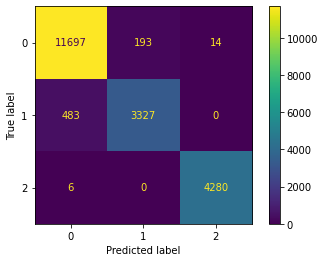

In [694]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)

print('Feature Importances: ', clf.feature_importances_)

# get predictions
predictions = clf.predict(X_test)

# inverse one hot encoding
predictions_enc = pd.DataFrame(predictions).idxmax(axis=1)
y_test_enc = pd.DataFrame(y_test).idxmax(axis=1)

# print accuracy
print('Accuracy: ', (predictions_enc == y_test_enc).mean())

# print classification report
print(classification_report(y_test_enc, predictions_enc))

# print confusion matrix
print(confusion_matrix(y_test_enc, predictions_enc))

# display confusion matrix as heatmap
ConfusionMatrixDisplay.from_predictions(y_test_enc, predictions_enc)

Below we can see the visualization of the decision tree with max_depth=5

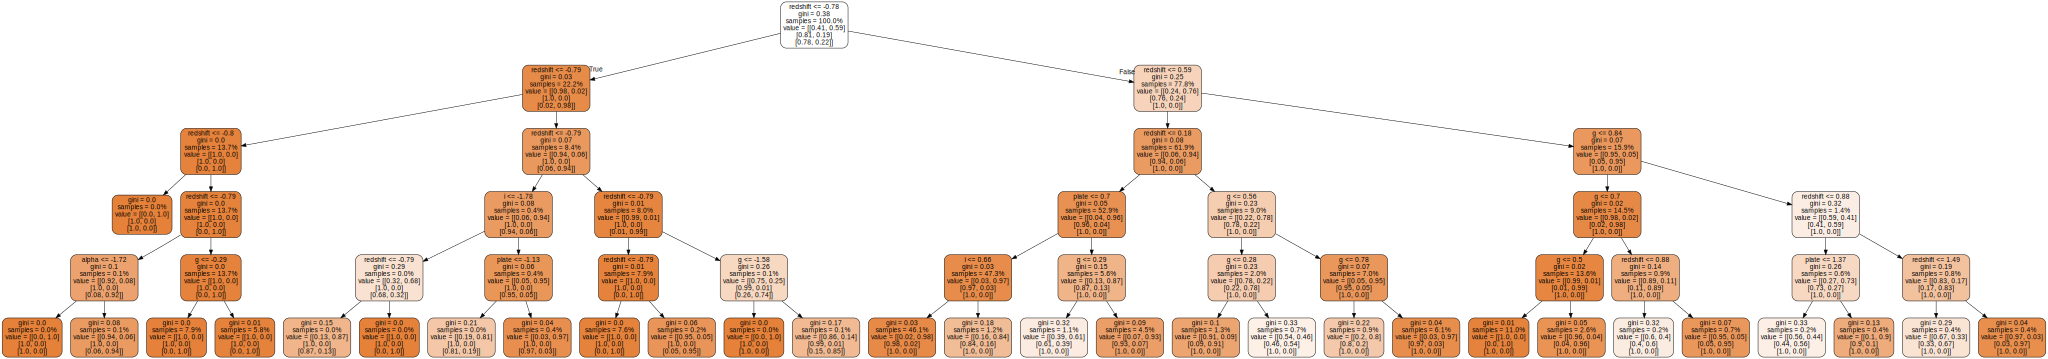

In [695]:
target_names = ['GALAXY', 'QSO', 'STAR']
dot_data = export_graphviz(clf, precision=2, feature_names=predictors, proportion=True,
                           class_names=target_names, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

## SVC

SVC does not require one-hot encoding, so we will instead use the 'class' column as our target.

In [696]:
# Set target
target = ['class']

# Set y
y = df[target].values.ravel()

# Train, Test, Split (Random Seed 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale X_train and X_test
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Accuracy:  0.9625
              precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     11904
         QSO       0.97      0.91      0.94      3810
        STAR       0.95      0.99      0.97      4286

    accuracy                           0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000

[[11537   124   243]
 [  347  3459     4]
 [   32     0  4254]]


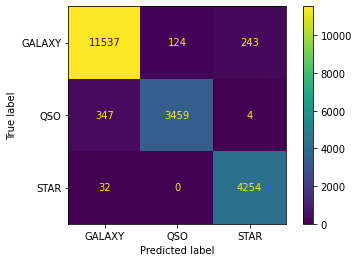

In [697]:
svc = SVC()
svc.fit(X_train, y_train)

predictions = svc.predict(X_test)

# print accuracy
print('Accuracy: ', (predictions == y_test).mean())

# print classification report
print(classification_report(y_test, predictions))

# get  confusion matrix
print(confusion_matrix(y_test, predictions))

# display confusion matrix as heatmap
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

## Logistic Regression

Accuracy:  0.95485
              precision    recall  f1-score   support

      GALAXY       0.96      0.96      0.96     11904
         QSO       0.94      0.88      0.91      3810
        STAR       0.95      1.00      0.97      4286

    accuracy                           0.95     20000
   macro avg       0.95      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000

[[11469   203   232]
 [  461  3347     2]
 [    0     5  4281]]


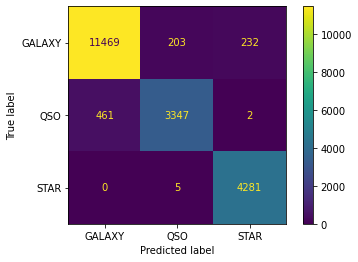

In [698]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

# print accuracy
print('Accuracy: ', (predictions == y_test).mean())

# print classification report
print(classification_report(y_test, predictions))

# get  confusion matrix
print(confusion_matrix(y_test, predictions))

# display confusion matrix as heatmap
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

The default solver algorithm (lbfgs) gives us a ConvergenceWarning. Let's use grid search to try different solver algorithms.

In [699]:
# we will try the different solver algorithms
params = {'solver':['newton-cg', 'liblinear', 'sag', 'saga']}

# grid search using 5-fold cross validation
clf_cv = GridSearchCV(LogisticRegression(), params, cv=5)
clf_cv.fit(X_train, y_train)

# print results
print('Best estimator:', clf_cv.best_estimator_)
print('Best accuracy:', clf_cv.best_score_)
print(clf_cv.cv_results_)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Best estimator: LogisticRegression(solver='newton-cg')
Best accuracy: 0.9566369069941872
{'mean_fit_time': array([5.34893932, 0.67312698, 3.03269043, 4.64398713]), 'std_fit_time': array([0.42673991, 0.02136968, 1.13269576, 1.83644752]), 'mean_score_time': array([0.03710246, 0.04105577, 0.05847621, 0.03652363]), 'std_score_time': array([0.00055648, 0.0040555 , 0.02585328, 0.00134613]), 'param_solver': masked_array(data=['newton-cg', 'liblinear', 'sag', 'saga'],
             mask=[False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'solver': 'newton-cg'}, {'solver': 'liblinear'}, {'solver': 'sag'}, {'solver': 'saga'}], 'split0_test_score': array([0.9545625, 0.9354375, 0.9544375, 0.9543125]), 'split1_test_score': array([0.95825  , 0.9370625, 0.95825  , 0.95825  ]), 'split2_test_score': array([0.9590625, 0.9408125, 0.9590625, 0.959    ]), 'split3_test_score': array([0.95875 , 0.934875, 0.95875 , 0.95875 ]), 'split4_test_score': array([0.95255953, 0.92

# Chosen Model

Show decision tree code, graph of hits vs misses and where the majority occurred

## Accuracy

In [700]:
#Label encoding
df['class_cat'] = df['class'].astype('category').cat.codes
predictors = ['alpha', 'delta', 'g', 'r', 'i', 'redshift', 'plate']
X = df[predictors]
y = df['class_cat']
#TTS
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#default
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
train_predict = clf.predict(X_train)
train_error = (train_predict != y_train).mean()
test_predict = clf.predict(X_test)
test_error = (test_predict != y_test).mean()
train_accuracy = 1 - train_error
test_accuracy = 1 - test_error

print("Training accuracy:", str("{:.2f}".format(100*train_accuracy)) + "%")
print("Test accuracy:", str("{:.2f}".format(100*test_accuracy)) + "%")

Training accuracy: 100.00%
Test accuracy: 96.38%


## Misclassifications

Per the previous section's confusion matrix, it can be seen that the majority of misclassifications are GALAXY/QSO misclassifications. Furthermore, these misclassifications tend to happen in a specific redshift and g range. Let's take a look at them

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning



Total misclassified: 724
Total misclassified in redshift range:[ 0.05 1.7 ]: 579 
 GALAXY classified as QSO    302
QSO classified as GALAXY    277
Name: misclassified, dtype: int64 



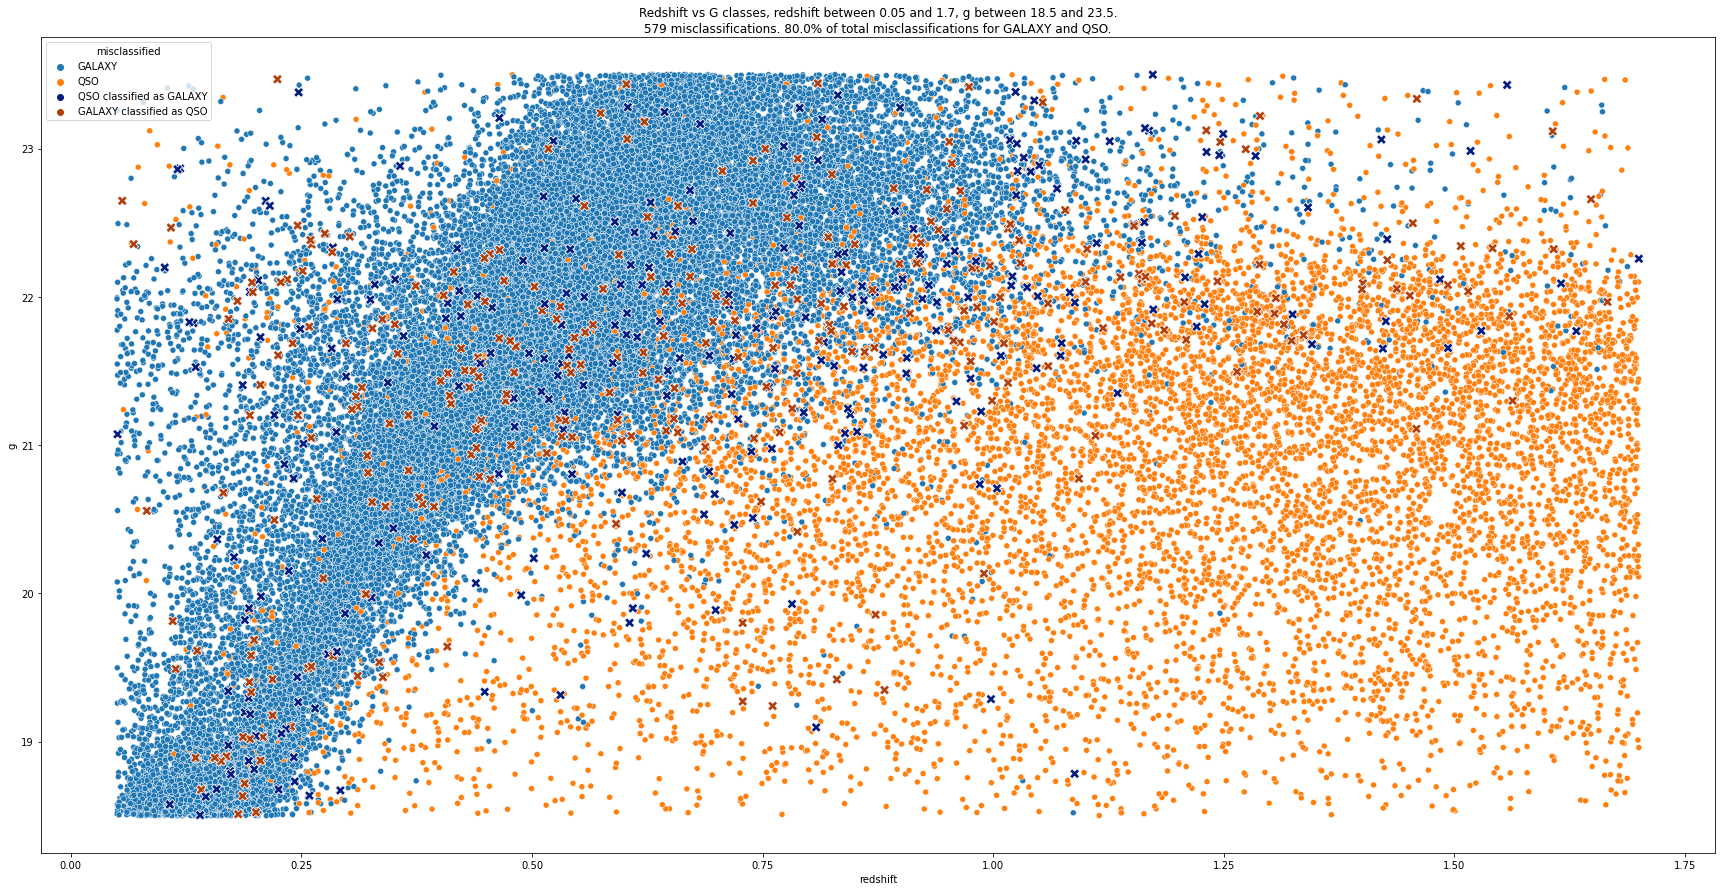

In [701]:
#Data
fig, ax = plt.subplots(figsize = (30,15))
redshift_range_upper = 1.7
redshift_range_lower = 0.05
g_range_upper = 23.5
g_range_lower = 18.5
# df_small = df[(df['redshift'] < redshift_range_upper) & (df['redshift'] > redshift_range_lower)]
df_small = df[(df['redshift'] < redshift_range_upper) & (df['redshift'] > redshift_range_lower) & (df['g'] < g_range_upper) & (df['g'] > g_range_lower)]
object_counts = df_small['class'].value_counts()
object_percentages = 100*(df_small['class'].value_counts() / df['class'].value_counts())
sns.scatterplot(df_small['redshift'], df_small['g'], hue=df_small['class'], ax=ax)
handles, labels  =  ax.get_legend_handles_labels()
labels = [ 'GALAXY: ' + str(object_counts['GALAXY']) + ' (' + str(round(object_percentages['GALAXY'], 2)) + '% of total data)', 
          'QSO: ' + str(object_counts['QSO']) + ' (' + str(round(object_percentages['QSO'], 2)) + '% of total data)']
ax.legend(handles, labels, loc='lower left')

#Misclassifications
misclassified_train = X_train[train_predict != y_train]
misclassified_test = X_test[test_predict != y_test]
shared_indices = []
for index in misclassified_test.index.values:
    if (index in df_small.index):
        shared_indices.append(index)
misclassified_in_df_small = df_small.loc[shared_indices]
misclassified_in_df_small['misclassified'] = misclassified_in_df_small['class'].apply(lambda x: 'GALAXY classified as QSO' if x=='GALAXY' else 'QSO classified as GALAXY')
sns.scatterplot(misclassified_in_df_small['redshift'], misclassified_in_df_small['g'], hue=misclassified_in_df_small['misclassified'], marker='X', palette='dark', s=100, ax=ax)

ax.set_title('Redshift vs G classes, redshift between ' + str(redshift_range_lower) + ' and ' + str(redshift_range_upper) + ', g between ' + str(g_range_lower) + ' and ' + str(g_range_upper) + '.\n' + str(misclassified_in_df_small.shape[0]) + ' misclassifications. ' + str(100*round((misclassified_in_df_small.shape[0] / misclassified_test.shape[0]), 2)) + '% of total misclassifications for GALAXY and QSO.')
# ax.set_title('Redshift vs G classes, redshift between ' + str(redshift_range_lower) + ' and ' + str(redshift_range_upper) + '.\n' + str(misclassified_in_df_small.shape[0]) + ' misclassifications. ' + str(100*round((misclassified_in_df_small.shape[0] / misclassified_test.shape[0]), 2)) + '% of total misclassifications for GALAXY and QSO.')
print("\nTotal misclassified:", misclassified_test.shape[0])
print("Total misclassified in redshift range:[", str(redshift_range_lower), str(redshift_range_upper), "]:", misclassified_in_df_small.shape[0], '\n', misclassified_in_df_small['misclassified'].value_counts(), '\n')
#Drop labels
df.drop(columns=['class_cat'], inplace=True)

# Bonus: Our model in action 

## Import SDSS data set from previous year (2016)

We have to be wary of overlap between our set and the set from the former year. Let's clean up the columns and get rid of the duplicates

In [702]:
#2016 SDSS data
df_sdss_2016 = pd.read_csv("star_classification_2016.csv")

#Clean up data and match columns to main data
df_sdss_2016.rename(columns={'object_id': 'obj_ID', 'right_ascension': 'alpha', 'declination': 'delta', 'u_magnitude': 'u', 
                       'g_magnitude': 'g','r_magnitude': 'r','i_magnitude': 'i','z_magnitude': 'z',
                       'obs_run_number': 'run_ID', 'rerun_number': 'rerun_ID', 'camera_column': 'cam_col', 
                       'field_number': 'field_ID', 'spectro_object_id': 'spec_obj_ID', 'plate_id': 'plate',
                       'observation_date': 'MJD', 'fiber_id': 'fiber_ID'}, inplace=True, errors='raise')

#drop duplicates in 2016 set 
df_sdss_2016.drop_duplicates(subset=['obj_ID'], inplace=True)

#reread the original dataframe to get obj_ID back
df_og = pd.read_csv("star_classification.csv")

#find overlapping rows in main set and 2016 set
obj_id_set = set(df_sdss_2016['obj_ID'])
ids_to_drop = []
for obj_id in df_og['obj_ID']:
    if obj_id in obj_id_set:
        ids_to_drop.append(obj_id)

#remove overlapping rows between main set and 2016 set 
df_sdss_2016 = df_sdss_2016[df_sdss_2016['obj_ID'].isin(ids_to_drop) == False]

#drop non-used columns
df_sdss_2016.drop(columns=['obj_ID', 'run_ID', 'rerun_ID', 'field_ID','fiber_ID', 'spec_obj_ID', 'MJD', 'cam_col', 'u', 'z'], inplace=True)

#drop bad data
bad_indices = df_sdss_2016[(df_sdss_2016['i'] == -9999)].index
df_sdss_2016.drop(bad_indices, inplace=True) #drop the bad data
df_sdss_2016.reset_index(drop=True, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Testing our model against these 732,646 new objects

In [703]:
#Label encoding
df_sdss_2016['class_cat'] = df_sdss_2016['class'].astype('category').cat.codes
predictors = ['alpha', 'delta', 'g', 'r', 'i', 'redshift', 'plate']
X = df_sdss_2016[predictors].values
y = df_sdss_2016['class_cat'].values

#Using our already trained model to predict all 732,646 new objects
test_predict = clf.predict(X)
test_error = (test_predict != y).mean()
test_accuracy = 1 - test_error
print("Number of objects predicted:", len(test_predict))
print("Accuracy:", str("{:.2f}".format(100*test_accuracy)) + "%")

Number of objects predicted: 732646
Accuracy: 98.27%


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"
